In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import sklearn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.neighbors import KDTree
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
nltk.download('wordnet')
import matplotlib.pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/india-headlines-news-dataset/india-news-headlines.csv
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data=pd.read_csv('/kaggle/input/india-headlines-news-dataset/india-news-headlines.csv')
data['cat']=data['headline_category'].str.split('.').map(lambda x : x[0])
data=data.loc[(data['cat']=='entertainment') | (data['cat']=='business') | (data['cat']=='sports') | (data['cat']=='india') ]

In [3]:
data1=data.loc[data['cat']=='sports'].head(15000)
data2=data.loc[data['cat']=='business'].head(15000)
data3=data.loc[data['cat']=='entertainment'].head(15000)
data4=data.loc[data['cat']=='india'].head(15000)
data=data1.append(data2).append(data3).append(data4)
data=data.sample(frac=1)
data=data.set_index(pd.Series([i for i in range(0,len(data))]))

In [4]:
#data=pd.DataFrame({"headline_text":np.array(data['headline_text'].sample(frac=0.1))})
#data['index']=data.index
#documents=data


In [5]:
#def lemmatize_stemming(text):
#    stemmer = PorterStemmer()
#    return WordNetLemmatizer().lemmatize(text, pos='v')
#def preprocess(text):
#    result = []
#    for token in gensim.utils.simple_preprocess(text):
#        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#            result.append(lemmatize_stemming(token))
#    return result

In [6]:
#doc_sample = documents[documents['index'] == 4310].values[0][0]
#print('original document: ')
#corp=[]
#for u in range(0,len(documents)):
#    words = []
#    for word in documents['headline_text'][u].split(' '):
#        words.append(word)
#    corp.append(words)


In [7]:
#processed_docs = documents['headline_text'].map(preprocess)
#processed_docs[:10]

In [8]:
def filter_func(sen):
    filter_list=['CC','RB','IN','TO','WRB','JJ','PRP','DT',':',')','(','POS','CD','.','MD']
    text=nltk.word_tokenize(sen)
    tagged=nltk.pos_tag(text)
    for g in tagged:
        if(g[1] in filter_list):
            text.remove(g[0])
    text1=[word.lower() for word in text]
    return(text1)
    

In [9]:
tags=[]
for i in range(0,len(data)):
    tags.append(filter_func(data['headline_text'][i]))

In [10]:
#corp=[]
#for i in list(data['headline_text']): 
#    corp.append(nltk.word_tokenize(i))

In [11]:
#import nltk
#nltk.download('stopwords')
#from nltk.tokenize import word_tokenize 
#from nltk.corpus import stopwords

In [12]:
#stop_words = set(stopwords.words('english')) 
#filtered=[]
#for i in range(0,len(corp)):
#    filtered.append([w for w in corp[i] if not w in stop_words]) 

# Topic exploration using Word embeddings

In [13]:
model = Word2Vec(tags, min_count=1,size=1000)
model.wv.vectors.shape
wordvecs=model.wv.vectors   


In [14]:
len(wordvecs)

26108

In [15]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;
centers, clusters = clustering_on_wordvecs(wordvecs, 7);
centroid_map = dict(zip(model.wv.index2word, clusters));

In [16]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
#Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
#Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
#A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return(df)


In [17]:
top_words = get_top_words(model.wv.index2word, 5000, centers, wordvecs);
top_words.head(20)

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6
1,cancun,stadiums,concern,militants,go,anupam,issues
2,errors,pets,line,kashmir,its,liquor,west
3,concludes,porcelain,awaits,pak,star,biotech,begins
4,ousts,andrews,planning,attack,launch,raja,rights
5,prayer,diverts,refuses,police,wins,note,officials
6,undergoes,hannibal,shilpa,bjp,launches,urged,brand
7,agony,kirron,ki,gujarat,more,racism,faces
8,privacy,usage,baby,pm,make,slam,wedding
9,branch,sanjaya,nfl,polls,new,jagmohan,bash
10,hamilton,psychologists,affect,injured,report,scrips,budget


In [18]:
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

#sns.set_style('whitegrid')
#%matplotlib inline
## Helper function
#def plot_20_most_common_words(count_data, count_vectorizer):
#    import matplotlib.pyplot as plt
#    words = count_vectorizer.get_feature_names()
#    total_counts = np.zeros(len(words))
#    for t in count_data:
#        total_counts+=t.toarray()[0]
#    
#    count_dict = (zip(words, total_counts))
#    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
#    words = [w[0] for w in count_dict]
#    counts = [w[1] for w in count_dict]
#    x_pos = np.arange(len(words)) 
#    
#    plt.figure(2, figsize=(12, 12/1.6180))
#    plt.subplot(title='30 most common words')
#    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
#    sns.barplot(x_pos, counts, palette='husl')
#    plt.xticks(x_pos, words, rotation=90) 
#    plt.xlabel('words')
#    plt.ylabel('counts')
#    plt.show()
## Initialise the count vectorizer with the English stop words
#count_vectorizer = TfidfVectorizer(stop_words='english')
## Fit and transform the processed titles
#count_data = count_vectorizer.fit_transform(data['headline_text'])
## Visualise the 20 most common words
#plot_20_most_common_words(count_data, count_vectorizer)

In [19]:
#import warnings
#warnings.simplefilter("ignore", DeprecationWarning)
## Load the LDA model from sk-learn
#from sklearn.decomposition import LatentDirichletAllocation as LDA
# 
## Helper function
#def print_topics(model, count_vectorizer, n_top_words):
#    words = count_vectorizer.get_feature_names()
#    for topic_idx, topic in enumerate(model.components_):
#        print("\nTopic #%d:" % topic_idx)
#        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
#        
## Tweak the two parameters below
#number_topics = 6
#number_words = 20
## Create and fit the LDA model
#lda = LDA(n_components=number_topics, n_jobs=-1)
#lda.fit(count_data)
## Print the topics found by the LDA model
#print("Topics found via LDA:")
#print_topics(lda, count_vectorizer, number_words)

# Latent dirichlet alloacation

In [20]:
from gensim import corpora, models
def bow(tags):
    dictionary = gensim.corpora.Dictionary(tags)
    bow_corpus = [dictionary.doc2bow(doc) for doc in tags]
    return(bow_corpus)

def bow_tfidf(tags):
    dictionary = gensim.corpora.Dictionary(tags)
    bow_corpus = [dictionary.doc2bow(doc) for doc in tags]
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    return(corpus_tfidf)

In [21]:
bow_corpus =bow(tags)
corpus_tfidf=bow_tfidf(tags)

In [22]:
#bow_doc_4310 = bow_corpus[4310]
#for i in range(len(bow_doc_4310)):
#    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0],dictionary[bow_doc_4310[i][0]],bow_doc_4310[i][1]))

In [23]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=gensim.corpora.Dictionary(tags), passes=2, workers=2)

In [24]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=6, id2word=gensim.corpora.Dictionary(tags), passes=2, workers=4)

In [25]:
#for idx, topic in lda_model.print_topics(-1):
#    print('Topic: {} \nWords: {}'.format(idx, topic))

In [26]:
#for idx, topic in lda_model_tfidf.print_topics(-1):
#    print('Topic: {} Word: {}'.format(idx, topic))

In [27]:
#for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
#    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


In [28]:
#for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
#    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

In [29]:
#unseen_document = 'Two suspects killed by police'
#unseen2='One more lok sabha constituency added'
#unseen3='Modi ji doubts over ballot papers'
#bow_vector = dictionary.doc2bow(preprocess(unseen_document))
#bow_vector3=dictionary.doc2bow(preprocess(unseen2))
#bow_vector4=dictionary.doc2bow(preprocess(unseen3))

#for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
#    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


In [30]:
flag=[]
for i in range(0,len(bow_corpus)):
    vec=[0]*6
    for j in lda_model_tfidf[corpus_tfidf[i]]:
        vec[j[0]]=j[1]
    vec=np.array(vec)
    flag.append(vec)
    
    

In [31]:
flag2=[]
for i in range(0,len(bow_corpus)):
    vec=[0]*6
    for j in lda_model[bow_corpus[i]]:
        vec[j[0]]=j[1]
    vec=np.array(vec)
    flag2.append(vec)
    
    

In [32]:
def get_topic(c):
    return(sorted(lda_model_tfidf[bow_corpus[c]], key=lambda tup: -1*tup[1])[0][0])

In [33]:
def get_sents(num,a):
    sents=[]
    for i in range(0,num):
        p=get_topic(i)
        if(p==a):
            sents.append(data['cat'][i])
    return(sents)

In [34]:
import matplotlib.pyplot as plt
def plot_cat(f):
    cats=['business','sports','entertainment','india']
    cout=[]
    for i in range(0,4):
        cout.append(get_sents(len(bow_corpus),f).count(cats[i]))
    plt.bar(cats,cout)
        
    

In [35]:
#plot_cat(2)

# Clustering the vectors generated by LDA

In [102]:
from sklearn import mixture
from sklearn.cluster import AffinityPropagation

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
#g = mixture.GaussianMixture(n_components=6)
g=KMeans(n_clusters=6)
#g=AffinityPropagation()
g.fit(flag)
labels=g.labels_

In [103]:
def get_label(a):
    cats=['business','sports','entertainment','india']
    lb=[]
    cout=[]
    for i in range(0,len(labels)):
        if(labels[i]==a):
            lb.append(data['cat'][i])
    for i in range(0,4):
        cout.append(lb.count(cats[i]))
    plt.bar(cats,cout)

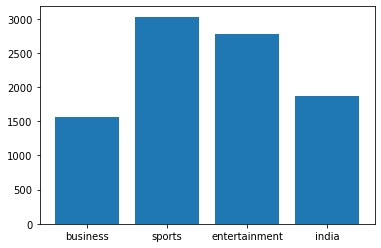

In [104]:
get_label(0)

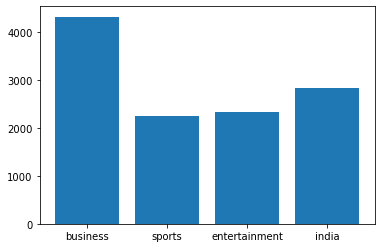

In [105]:
get_label(1)  #sports

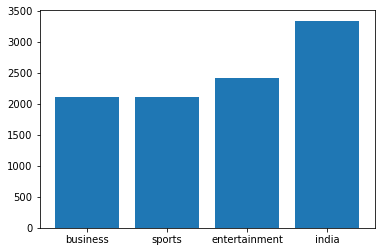

In [106]:
get_label(2)  #business

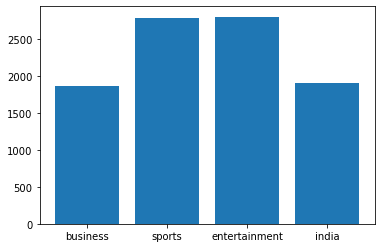

In [107]:
get_label(3)  #sports

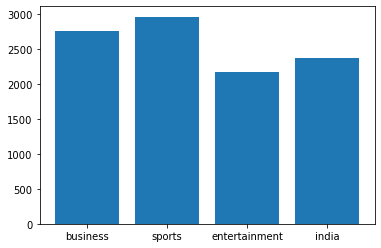

In [108]:
get_label(4)    #entertainment

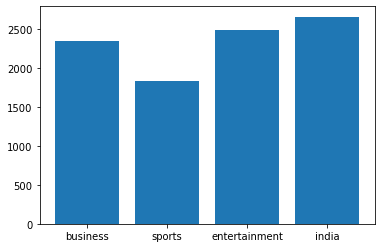

In [109]:
get_label(5)   #india

In [110]:
def pred_func(sent):
    sef=filter_func(sent)
    b=bow_tfidf([sef])[0]
    lvec=[0]*6
    for j in lda_model_tfidf[b]:
        lvec[j[0]]=j[1]
    lvec=np.array(lvec)
    print(lvec)
    pred=g.predict([lvec])[0]
    print(pred)

In [111]:
pred_func(data['headline_text'][9])

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
5
